In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal, interpolate
import pandas as pd

import h5py

# Set font size for plots
matplotlib.rcParams['font.size'] = 8

# Create time vector

cm = 1/2.54  # cm to inches


# Load data from csv using numpy
# Load data from CSV using pandas, ensuring 'field' is read as string
pump_df = pd.read_csv('FilteredWaveformDeg.csv', delimiter=',', dtype={'field': str})

# Funktion zum Parsen von komplexen Zahlen aus Strings
def parse_complex(s):
    s = s.replace('im', 'j')  # Ersetze 'im' durch 'j'
    s = s.replace(' ', '')      # Entferne Leerzeichen
    return complex(s)

# Konvertiere die 'field'-Spalte in komplexe Zahlen
pump_df['field'] = pump_df['field'].apply(parse_complex)

# Optional: Konvertiere das DataFrame in ein numpy-Array, falls benötigt
pump = pump_df.to_numpy()

pumpField = pump[:,1]

referencePulse = np.loadtxt('ReferencePulse.csv', delimiter=',',skiprows=1)

refField = referencePulse[:,1]

Sampled = np.loadtxt('SampledArtificialWaveformHighRes.csv', delimiter=',',skiprows=1)

convolutedSignal = Sampled[:,1]


t = Sampled[:,0]

tPump =pump[:,0].astype(float)



C:\Users\ritzk\AppData\Local\Temp\ipykernel_3356\2154598399.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  tPump =pump[:,0].astype(float)


c:\Users\ritzk\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


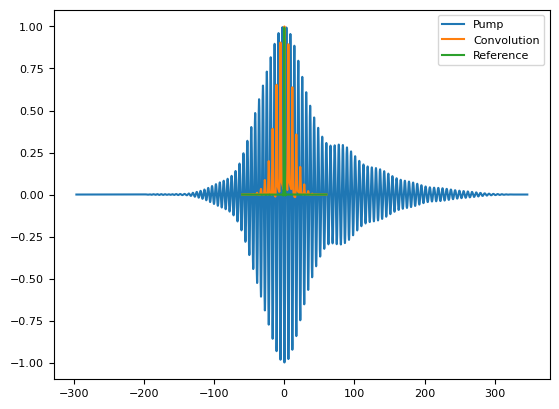

In [12]:
plt.plot(tPump,pumpField,label='Pump')
plt.plot(t,convolutedSignal,label='Convolution')
plt.plot(t,refField,label='Reference')
plt.legend()

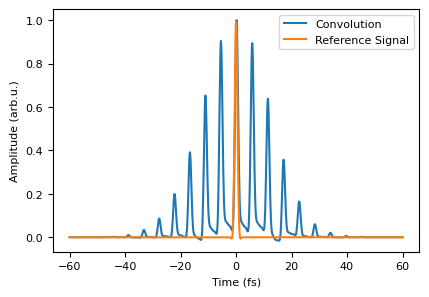

In [13]:
plt.figure(figsize=(cm*12, cm*8))

plt.plot(t,convolutedSignal,label='Convolution')
plt.plot(t,refField,label='Reference Signal')
plt.xlabel('Time (fs)')
plt.ylabel('Amplitude (arb.u.)')
plt.legend()
plt.savefig('Convolution.png', dpi=300)

(1e-08, 1000.0)

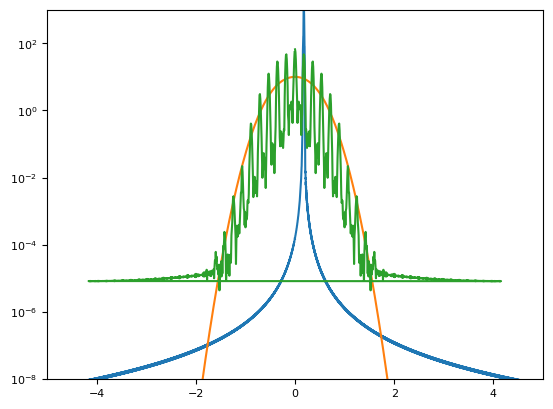

In [14]:
# Plot spectral domain of signals
freq = np.fft.fftfreq(len(t), t[1] - t[0])
pumpFreq = np.fft.fftfreq(len(tPump), tPump[1] - tPump[0])

pumpField_f = np.fft.fft(pumpField)
refField_f = np.fft.fft(refField)
convolutedSignal_f = np.fft.fft(convolutedSignal)


plt.figure()
plt.semilogy(pumpFreq, np.abs(pumpField_f), label='Pump')
plt.semilogy(freq, np.abs(refField_f), label='Reference')
plt.semilogy(freq, np.abs(convolutedSignal_f), label='Convolution')
plt.xlim(-5,5)
plt.ylim(1e-8,1e3)


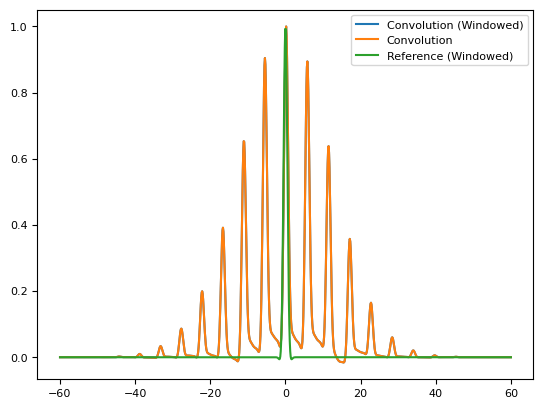

In [15]:
# Optional: Apply a window function to reduce edge effects
window = signal.windows.tukey(len(t),alpha=0.3)
convoluted_signal_windowed = convolutedSignal * window
refField_windowed = refField * window

plt.figure()
plt.plot(t, convoluted_signal_windowed, label='Convolution (Windowed)')
plt.plot(t, convolutedSignal, label='Convolution')
plt.plot(t, refField_windowed, label='Reference (Windowed)')

plt.legend()


C:\Users\ritzk\AppData\Local\Temp\ipykernel_3356\2690656018.py:13: RuntimeWarning: divide by zero encountered in divide
  out = np.heaviside(real_inField, 1) * (real_inField * fieldEnhancement) ** 2 * np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))


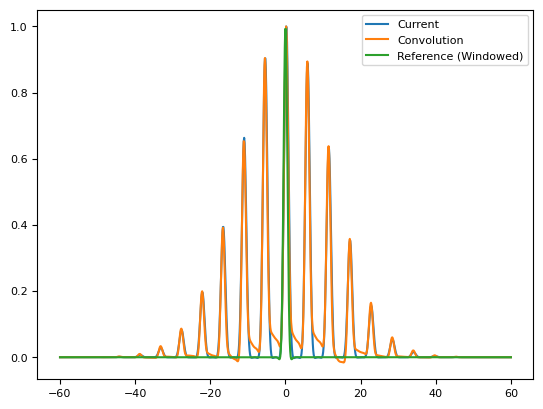

In [16]:


def FNemission(inField, criticalField, fieldEnhancement):
    """
    Calculate the emission field based on the input field, critical field, and field enhancement factor.
    Parameters:
    inField (numpy.ndarray): The input field, which is a complex array.
    criticalField (float): The critical field value.
    fieldEnhancement (float): The field enhancement factor.
    Returns:
    numpy.ndarray: The calculated emission field.
    """
    real_inField = np.real(inField)
    
    out = np.heaviside(real_inField, 1) * (real_inField * fieldEnhancement) ** 2 * np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))
    
    return out

def FNemissionDerivative(inField, criticalField, fieldEnhancement):
    real_inField = np.real(inField)
    heaviside_vals = np.heaviside(real_inField, 1)
    exp_term = np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))
    term1 = real_inField * fieldEnhancement ** 2 * exp_term
    term2 = fieldEnhancement ** 2 * criticalField * exp_term
    derCurrent = -heaviside_vals * 2 * (term1 - term2)
    return derCurrent

# Calculating the cross correlation using fowler nordheim function

# interpolating the reference signal to the same time points as the convolution signal
f = interpolate.interp1d(t, refField, kind='linear', fill_value='extrapolate')

current = np.zeros_like(t)

for i,value in enumerate(t):
    current[i] = np.sum(FNemission( -pumpField + (1/3300)* f(tPump-t[i]),76,15)) *(tPump[1]-tPump[0])

current -= current[0]

current = current/np.max(current)
dt = t[1] - t[0]
plt.figure()
plt.plot(t, current , label='Current')
plt.plot(t, convolutedSignal, label='Convolution')
plt.plot(t, refField_windowed, label='Reference (Windowed)')
plt.legend()

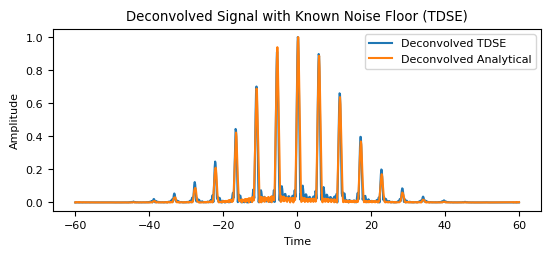

In [17]:
window = signal.windows.tukey(len(t),alpha=0.3)

convoluted_signal_windowed = convolutedSignal * window
refField_windowed = refField * window

# Compute the FFTs
fft_convoluted = np.fft.fft(convoluted_signal_windowed)
fft_convolutedAnalytical = np.fft.fft(current)

fft_refField = np.fft.fft(refField_windowed)


# Compute the conjugate of the reference field FFT
H_conj = np.conj(refField_f)

# Compute the power spectral density of the reference field
S_xx = np.abs(refField_f) ** 2

# Compute the Wiener filter using the known noise power spectrum
wiener_filter = H_conj / (S_xx + 1e-4)
wiener_filterAnalytical = H_conj / (S_xx + 1e-15)

# Apply the Wiener filter
fft_deconvolved = fft_convoluted * wiener_filter
fft_deconvolvedAnalytical = fft_convolutedAnalytical * wiener_filterAnalytical

# Compute the inverse FFT to get the deconvolved signal
deconvolved_signal = np.fft.ifft(fft_deconvolved)
deconvolved_signalAnalytical = np.fft.ifft(fft_deconvolvedAnalytical)

# Take the real part of the signal
deconvolved_signal_real = np.abs(deconvolved_signal)
deconvolved_signalAnalytical_real = np.abs(deconvolved_signalAnalytical)

deconvolved_signal_real2 = np.fft.ifftshift(deconvolved_signal_real)
deconvolved_signalAnalytical_real2 = np.fft.ifftshift(deconvolved_signalAnalytical_real)

plt.figure(figsize=(cm*16, cm*6))
plt.plot(t, deconvolved_signal_real2/np.max(deconvolved_signal_real2), label='Deconvolved TDSE')
plt.plot(t, deconvolved_signalAnalytical_real2/np.max(deconvolved_signalAnalytical_real2), label='Deconvolved Analytical')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Deconvolved Signal with Known Noise Floor (TDSE)')
plt.legend()
plt.show()


# saving both in csv files
np.savetxt('DeconvolvedSignalTDSE.csv', np.column_stack((t, deconvolved_signal_real2)), delimiter=',', header='Time,Amplitude', comments='')
np.savetxt('DeconvolvedSignalAnalytical.csv', np.column_stack((t, deconvolved_signalAnalytical_real2)), delimiter=',', header='Time,Amplitude', comments='')



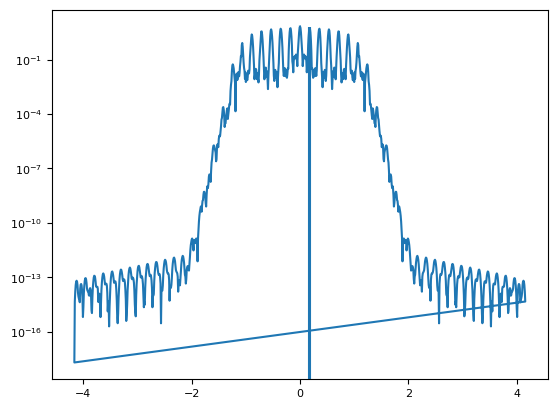

In [18]:
plt.semilogy(freq,np.abs(fft_deconvolved))

# plt.xlim(0.125,0.225)
plt.vlines(0.193,0,6)
plt.vlines(0.162,0,6)





C:\Users\ritzk\AppData\Local\Temp\ipykernel_3356\2690656018.py:20: RuntimeWarning: divide by zero encountered in divide
  exp_term = np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))


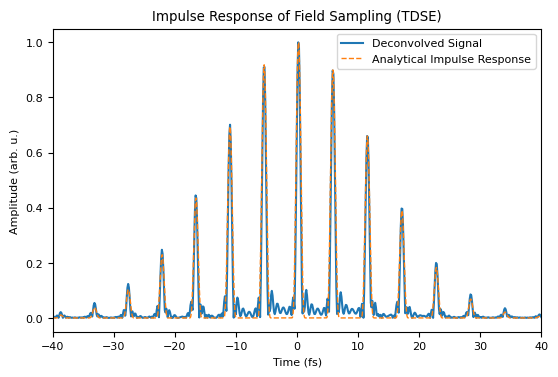

In [19]:
deconvolved_signal_real2 = np.fft.ifftshift(deconvolved_signal_real)

plt.figure(figsize=(cm*16, cm*10))
plt.plot(t, deconvolved_signal_real2/np.max(deconvolved_signal_real2), label='Deconvolved Signal')

plt.plot(tPump,FNemissionDerivative(-pumpField, 76, 15)/np.max(FNemissionDerivative(-pumpField, 76, 15)),linestyle="--",label='Analytical Impulse Response',linewidth=1)
# plt.plot(t,convolutedSignal/np.max(convolutedSignal),label='Convoluted Signal')
plt.xlabel('Time (fs)')
plt.xlim(-40,40)
plt.ylabel('Amplitude (arb. u.)')
plt.title('Impulse Response of Field Sampling (TDSE)')
plt.legend(loc='upper right')
plt.savefig('ImpulseResponseTDSE_2.png', dpi=600)
plt.show()

C:\Users\ritzk\AppData\Local\Temp\ipykernel_3356\2690656018.py:20: RuntimeWarning: divide by zero encountered in divide
  exp_term = np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))


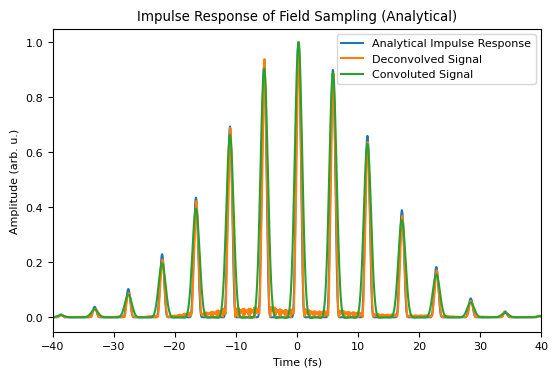

In [20]:

plt.figure(figsize=(cm*16, cm*10))

plt.plot(tPump,FNemissionDerivative(-pumpField, 76, 15)/np.max(FNemissionDerivative(-pumpField, 76, 15)),label='Analytical Impulse Response')
plt.plot(t, deconvolved_signalAnalytical_real2/np.max(deconvolved_signalAnalytical_real2), label='Deconvolved Signal')
plt.plot(t,current,label='Convoluted Signal')
plt.xlabel('Time (fs)')
plt.xlim(-40,40)
plt.ylabel('Amplitude (arb. u.)')
plt.title('Impulse Response of Field Sampling (Analytical)')
plt.legend(loc='upper right')
plt.savefig('ImpulseResponseAnalytical.png', dpi=600)
plt.show()

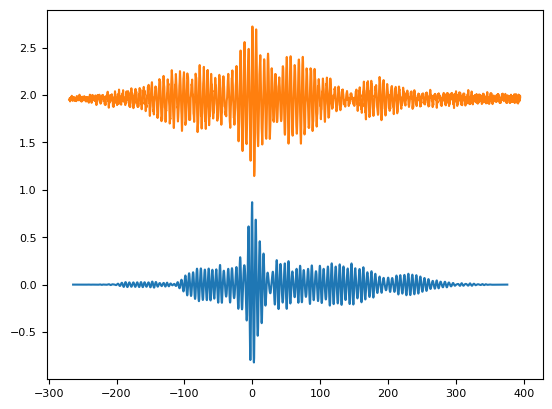

In [31]:
# Deconvoluting the measured signal using the analytical functions  
# Read CSV files with complex values
signal_data = np.genfromtxt("FilteredWaveformSCG0415.csv", delimiter=',', dtype=complex)





signal_time = signal_data[:, 0].real
signal_values = signal_data[:, 1]

# Interpolate the signal to the same time points as the pump and reference signals
interpSignal = interpolate.interp1d(
    np.flip(signal_time),
    np.flip(signal_values.real),
    kind='linear',
    fill_value=0,
    bounds_error=False
)


vars = loadmat("Waveforms/nondegenerate.mat")

# with h5py.File("Waveforms/AllTraces.mat", 'r') as f:
#     # List all groups
#     print("Keys: %s" % f.keys())
#     # Get the data
#     vars2 = {key: np.array(f[key]) for key in f.keys()}

# Reverse and flatten the time and field arrays
meas1Time = np.flip(vars["nondegen_20230415_10ms_longgateshortsig_time"].flatten())
meas1Field = np.flip(vars["nondegen_20230415_10ms_longgateshortsig_total"].flatten())




# Compute Hilbert transform and normalize
meas1Cmplx = signal.hilbert(meas1Field)
meas1Cmplx = meas1Cmplx / np.max(np.abs(meas1Cmplx))

# Create interpolation function with extrapolation value 0
interpMeas = interpolate.interp1d(
    meas1Time,
    meas1Cmplx.real,
    kind='linear',
    fill_value=0,
    bounds_error=False
)

plt.plot(signal_time, signal_values.real)
plt.plot(meas1Time, meas1Field+2)



In [32]:
convFunction = FNemissionDerivative(-pumpField, 76, 15)/np.max(FNemissionDerivative(-pumpField, 76, 15))
signalFunction = interpSignal(tPump)
LongGate = interpMeas(tPump)

print(signalFunction.shape)

(10000,)


C:\Users\ritzk\AppData\Local\Temp\ipykernel_3356\2690656018.py:20: RuntimeWarning: divide by zero encountered in divide
  exp_term = np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))


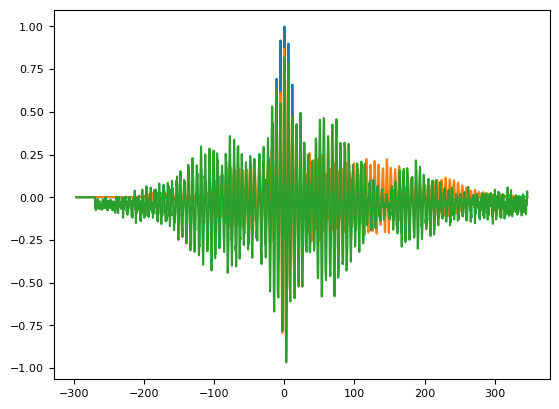

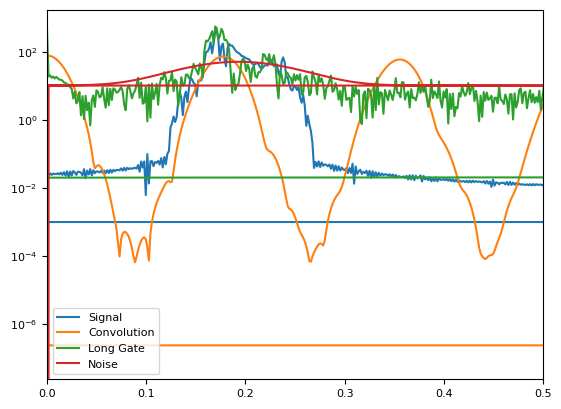

In [66]:
plt.plot(tPump,convFunction,label='Impulse Response')
plt.plot(tPump,signalFunction,label='Signal')
plt.plot(tPump,LongGate,label='Long Gate')
plt.show()

freq = np.fft.fftfreq(len(tPump), tPump[1] - tPump[0])

spectrumSignal = np.fft.fft(signalFunction)
spectrumConv = np.fft.fft(convFunction)
spectrumGate = np.fft.fft(LongGate)

Noise = np.ones_like(spectrumSignal)*10 + 40*np.exp(- (freq-0.193)**2/0.005) +40*np.exp(- (freq+0.193)**2/0.005)
Noise[0] = 0



plt.semilogy(freq,np.abs(spectrumSignal),label='Signal')
plt.semilogy(freq,np.abs(spectrumConv),label='Convolution')
plt.semilogy(freq,np.abs(spectrumGate),label='Long Gate')
plt.semilogy(freq,np.abs(Noise),label='Noise')
plt.legend()
plt.xlim(0,0.5)
plt.show()


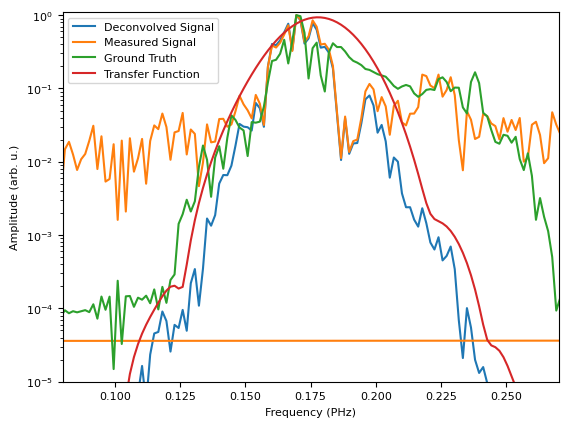

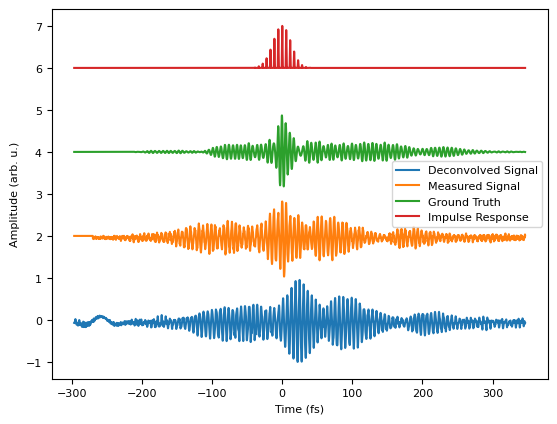

In [ ]:
# deconvolution of the measured signal

deconv = (np.conj(spectrumConv)/(np.abs(spectrumConv)**2 + np.abs(Noise)**2)) * spectrumGate

plt.semilogy(freq,np.abs(deconv)/np.max(np.abs(deconv)),label='Deconvolved Signal')
plt.semilogy(freq,np.abs(spectrumGate)/np.max(np.abs(spectrumGate)),label='Measured Signal')
plt.semilogy(freq,np.abs(spectrumSignal)/np.max(np.abs(spectrumSignal)),label='Ground Truth')
plt.semilogy(freq,np.abs(spectrumConv)/np.max(np.abs(spectrumConv)),label='Transfer Function')
plt.xlim(0.08,0.27)
plt.ylim(1e-5,1.1)
plt.xlabel('Frequency (PHz)')
plt.ylabel('Amplitude (arb. u.)')
plt.legend()
plt.title("Frequency Domain - Deconvolution")

plt.show()


# calculate the time domain signal
deconvSignal = np.fft.ifftshift(np.fft.ifft(deconv))

plt.plot(tPump,deconvSignal/np.max(np.abs(deconvSignal)),label='Deconvolved Signal')
plt.plot(tPump,LongGate + 2,label='Measured Signal')
plt.plot(tPump,signalFunction + 4,label='Ground Truth')
plt.plot(tPump,convFunction + 6,label='Impulse Response')
plt.xlabel('Time (fs)')
plt.ylabel('Amplitude (arb. u.)')
plt.title("Time Domain - Deconvolution")

plt.legend()
plt.show()

